# 多GPU训练
:label:`sec_multi_gpu`

到目前为止，我们讨论了如何在 CPU 和 GPU 上高效地训练模型，同时在 :numref:`sec_auto_para` 中展示了深度学习框架如何在 CPU 和 GPU 之间自动地并行化计算和通信，还在 :numref:`sec_use_gpu` 中展示了如何使用 `nvidia-smi` 命令列出计算机上所有可用的 GPU。
但是我们没有讨论如何真正实现深度学习训练的并行化。
是否一种方法，以某种方式分割数据到多个设备上，并使其能够正常工作呢？
本节将详细介绍如何从零开始并行地训练网络，
这里需要运用小批量随机梯度下降算法（详见 :numref:`sec_minibatch_sgd` ）。
后面我还讲介绍如何使用高级API并行训练网络（请参阅 :numref:`sec_multi_gpu_concise` ）。

## 问题拆分

我们从一个简单的计算机视觉问题和一个稍稍过时的网络开始。
这个网络有多个卷积层和汇聚层，最后可能有几个全连接的层，看起来非常类似于 LeNet :cite:`LeCun.Bottou.Bengio.ea.1998` 或 AlexNet :cite:`Krizhevsky.Sutskever.Hinton.2012` 。
假设我们有多个 GPU（如果是桌面服务器则有 $2$ 个，AWS g4dn.12xlarge 上有 $4$ 个，p3.16xlarge 上有 $8$ 个，p2.16xlarge 上有 $16$ 个）。
我们希望以一种方式对训练进行拆分，为实现良好的加速比，还能同时受益于简单且可重复的设计选择。
毕竟，多个 GPU 同时增加了内存和计算能力。
简而言之，对于需要分类的小批量训练数据，我们有以下选择。

第一种方法，在多个 GPU 之间拆分网络。
也就是说，每个 GPU 将流入特定层的数据作为输入，跨多个后续层对数据进行处理，然后将数据发送到下一个 GPU。
与单个 GPU 所能处理的数据相比，我们可以用更大的网络处理数据。
此外，每个 GPU 占用的 *显存* （memory footprint）可以得到很好的控制，虽然它只是整个网络显存的一小部分。

然而，GPU的接口之间需要的密集同步可能是很难办的，特别是层之间计算的工作负载不能正确匹配的时候，
还有层之间的接口需要大量的数据传输的时候（例如：激活值和梯度，数据量可能会超出GPU总线的带宽）。
此外，计算密集型操作的顺序对于拆分来说也是非常重要的，这方面的最好研究可参见 :cite:`Mirhoseini.Pham.Le.ea.2017`，其本质仍然是一个困难的问题，目前还不清楚研究是否能在特定问题上实现良好的线性缩放。
综上所述，除非存框架或操作系统本身支持将多个 GPU 连接在一起，否则不建议这种方法。

第二种方法，拆分层内的工作。
例如，将问题分散到 $4$ 个 GPU，每个 GPU 生成 $16$ 个通道的数据，而不是在单个 GPU 上计算 $64$ 个通道。
对于全连接的层，同样可以拆分输出单元的数量。
 :numref:`fig_alexnet_original` 描述了这种设计，其策略用于处理显存非常小（当时为2GB）的GPU。
 当通道或单元的数量不太小时，使计算性能有良好的提升。
 此外，由于可用的显存呈线性扩展，多个 GPU 能够处理不断变大的网络。

![由于GPU显存有限，原有AlexNet设计中的模型并行。](../img/alexnet-original.svg)
:label:`fig_alexnet_original`

然而，我们需要大量的同步或*屏障操作*(barrier operations)，因为每一层都依赖于所有其他层的结果。
此外，需要传输的数据量也可能比跨 GPU 拆分层时还要大。
因此，基于带宽的成本和复杂性，我们同样不推荐这种方法。

最后一种方法，跨多个 GPU 对数据进行拆分。
这种方式下，所有 GPU 尽管有不同的观测结果，但是执行着相同类型的工作。
在完成每个小批量数据的训练之后，梯度在 GPU 上聚合。
这种方法最简单，并可以应用于任何情况，同步只需要在每个小批量数据处理之后进行。
也就是说，当其他梯度参数仍在计算时，完成计算的梯度参数就可以开始交换。
而且，GPU 的数量越多，小批量包含的数据量就越大，从而就能提高训练效率。
但是，添加更多的 GPU 并不能让我们训练更大的模型。

![在多个GPU上并行化。从左到右：原始问题、网络并行、分层并行、数据并行。](../img/splitting.svg)
:label:`fig_splitting`

:numref:`fig_splitting` 中比较了多个 GPU 上不同的并行方式。
总体而言，只要 GPU 的显存足够大，数据并行是最方便的。
有关分布式训练分区的详细描述，请参见 :cite:`Li.Andersen.Park.ea.2014` 。
在深度学习的早期，GPU 的显存曾经是一个棘手的问题，然而如今除了非常特殊的情况，这个问题已经解决。
下面我们将重点讨论数据并行性。

## 数据并行性

假设一台机器有 $k$ 个 GPU。
给定需要训练的模型，虽然每个 GPU 上的参数值都是相同且同步的，但是每个 GPU 都将独立地维护一组完整的模型参数。
例如， :numref:`fig_data_parallel` 演示了在 $k=2$ 时基于数据并行方法训练模型。

![利用两个GPU上的数据，并行计算小批量随机梯度下降。](../img/data-parallel.svg)
:label:`fig_data_parallel`

一般来说，$k$ 个GPU并行训练过程如下：

* 在任何一次训练迭代中，给定的随机的小批量样本都将被分成 $k$ 个部分，并均匀地分配到 GPU 上。
* 每个 GPU 根据分配给它的小批量子集，计算模型参数的损失和梯度。
* 将 $k$ 个 GPU 中的局部梯度聚合，以获得当前小批量的随机梯度。
* 聚合梯度被重新分发到每个 GPU 中。
* 每个 GPU 使用这个小批量随机梯度，来更新它所维护的完整的模型参数集。

在实践中请注意，当在 $k$ 个 GPU 上训练时，需要扩大小批量的大小为 $k$ 的倍数，这样每个 GPU 都有相同的工作量，就像只在单个GPU上训练一样。
因此，在 16-GPU 服务器上可以显著地增加小批量数据量的大小，同时可能还需要相应地提高学习率。
还请注意， :numref:`sec_batch_norm` 中的批量归一化也需要调整，例如，为每个 GPU 保留单独的批量归一化参数。
下面我们将使用一个简单网络来演示多GPU训练。


In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


## [**简单网络**]

我们使用 :numref:`sec_lenet` 中介绍的（稍加修改的） LeNet，
从零开始定义它，从而详细说明参数交换和同步。


In [2]:
# 初始化模型参数
scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]

# 定义模型
def lenet(X, params):
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))
    h2 = h2.reshape(h2.shape[0], -1)
    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat

# 交叉熵损失函数
loss = nn.CrossEntropyLoss(reduction='none')

## 数据同步

对于高效的多 GPU 训练，我们需要两个基本操作。
首先，我们需要 [**向多个设备分发参数**] 并附加梯度（`get_params`）。
如果没有参数，就不可能在 GPU 上评估网络。
第二，需要跨多个设备对参数求和，也就是说，需要一个 `allreduce` 函数。


In [3]:
def get_params(params, device):
    new_params = [p.clone().to(device) for p in params]
    for p in new_params:
        p.requires_grad_()
    return new_params

通过将模型参数复制到一个GPU。


In [4]:
new_params = get_params(params, d2l.try_gpu(0))
print('b1 weight:', new_params[1])
print('b1 grad:', new_params[1].grad)

b1 weight: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
b1 grad: None


由于还没有进行任何计算，因此偏置参数的梯度仍然为零。
假设现在有一个向量分布在多个 GPU 上，下面的 [**`allreduce` 函数将所有向量相加，并将结果广播给所有 GPU**]。
请注意，我们需要将数据复制到累积结果的设备，才能使函数正常工作。


In [5]:
def allreduce(data):
    for i in range(1, len(data)):
        data[0][:] += data[i].to(data[0].device)
    for i in range(1, len(data)):
        data[i] = data[0].to(data[i].device)

通过在不同设备上创建具有不同值的向量并聚合它们。


In [6]:
data = [torch.ones((1, 2), device=d2l.try_gpu(i)) * (i + 1) for i in range(2)]
print('before allreduce:\n', data[0], '\n', data[1])
allreduce(data)
print('after allreduce:\n', data[0], '\n', data[1])

before allreduce:
 tensor([[1., 1.]], device='cuda:0') 
 tensor([[2., 2.]], device='cuda:1')
after allreduce:
 tensor([[3., 3.]], device='cuda:0') 
 tensor([[3., 3.]], device='cuda:1')


## 数据分发

我们需要一个简单的工具函数，[**将一个小批量数据均匀地分布在多个 GPU 上**]。
例如，有两个 GPU 时，我们希望每个 GPU 可以复制一半的数据。
因为深度学习框架的内置函数编写代码更方便、更简洁，所以在 $4 \times 5$ 矩阵上使用它进行尝试。


In [7]:
data = torch.arange(20).reshape(4, 5)
devices = [torch.device('cuda:0'), torch.device('cuda:1')]
split = nn.parallel.scatter(data, devices)
print('input :', data)
print('load into', devices)
print('output:', split)

input : tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])
load into [device(type='cuda', index=0), device(type='cuda', index=1)]
output: (tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]], device='cuda:0'), tensor([[10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]], device='cuda:1'))


为了方便以后复用，我们定义了可以同时拆分数据和标签的 `split_batch` 函数。


In [8]:
#@save
def split_batch(X, y, devices):
    """将`X`和`y`拆分到多个设备上"""
    assert X.shape[0] == y.shape[0]
    return (nn.parallel.scatter(X, devices),
            nn.parallel.scatter(y, devices))

## 训练

现在我们可以 [**在一个小批量上实现多 GPU 训练**]。
在多个 GPU 之间同步数据将使用刚才讨论的辅助函数 `allreduce` 和 `split_and_load`。
我们不需要编写任何特定的代码来实现并行性。
因为计算图在小批量内的设备之间没有任何依赖关系，因此它是“自动地”并行执行。


In [9]:
def train_batch(X, y, device_params, devices, lr):
    X_shards, y_shards = split_batch(X, y, devices)
    # 在每个GPU上分别计算损失
    ls = [loss(lenet(X_shard, device_W), y_shard).sum()
          for X_shard, y_shard, device_W in zip(
              X_shards, y_shards, device_params)]
    for l in ls:  # 反向传播在每个GPU上分别执行
        l.backward()
    # 将每个GPU的所有梯度相加，并将其广播到所有GPU
    with torch.no_grad():
        for i in range(len(device_params[0])):
            allreduce([device_params[c][i].grad for c in range(len(devices))])
    # 在每个GPU上分别更新模型参数
    for param in device_params:
        d2l.sgd(param, lr, X.shape[0]) # 在这里，我们使用全尺寸的小批量

现在，我们可以 [**定义训练函数**]。
与前几章中略有不同：训练函数需要分配 GPU 并将所有模型参数复制到所有设备。
显然，每个小批量都是使用 `train_batch` 函数来处理多个GPU。
我们只在一个 GPU 上计算模型的精确度，而让其他 GPU 保持空闲，尽管这是相对低效的，但是使用方便且代码简洁。


In [10]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    # 将模型参数复制到`num_gpus`个GPU
    device_params = [get_params(params, d) for d in devices]
    num_epochs = 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            # 为单个小批量执行多GPU训练
            train_batch(X, y, device_params, devices, lr)
            torch.cuda.synchronize()
        timer.stop()
        # 在GPU 0上评估模型
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(
            lambda x: lenet(x, device_params[0]), test_iter, devices[0]),))
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch '
          f'on {str(devices)}')

让我们看看 [**在单个GPU上运行**] 效果得有多好。
首先使用的批量大小是 $256$，学习率是 $0.2$。


test acc: 0.84, 2.5 sec/epoch on [device(type='cuda', index=0)]


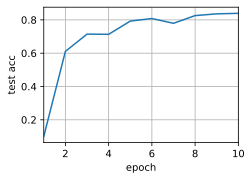

In [11]:
train(num_gpus=1, batch_size=256, lr=0.2)

保持批量大小和学习率不变，并 [**增加为2个GPU**]，我们可以看到测试精度与之前的实验基本相同。
不同的 GPU 个数在算法寻优方面是相同的。
不幸的是，这里没有任何有意义的加速：模型实在太小了；而且数据集也太小了，在这个数据集中，我们实现的多 GPU 训练的简单方法受到了巨大的 Python 开销的影响。
在未来，我们将遇到更复杂的模型和更复杂的并行化方法。
尽管如此，让我们看看 Fashion-MNIST 数据集上会发生什么。


test acc: 0.79, 2.6 sec/epoch on [device(type='cuda', index=0), device(type='cuda', index=1)]


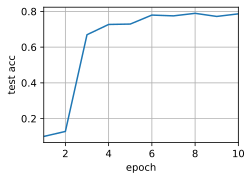

In [12]:
train(num_gpus=2, batch_size=256, lr=0.2)

## 小结

* 有多种方法可以在多个 GPU 上拆分深度网络的训练。拆分可以在层之间、跨层或跨数据上实现。前两者需要对数据传输过程进行严格编排，而最后一种则是最简单的策略。
* 数据并行训练本身是不复杂的，它通过增加有效的小批量数据量的大小提高了训练效率。
* 在数据并行中，数据需要跨多个 GPU 拆分，其中每个 GPU 执行自己的前向传播和反向传播，随后所有的梯度被聚合为一，之后聚合结果向所有的 GPU 广播。
* 小批量数据量更大时，学习率也需要稍微提高一些。

## 练习

1. 在 $k$ 个 GPU 上进行训练时，将批量大小从 $b$ 更改为 $k \cdot b$，即按 GPU 的数量进行扩展。
1. 比较不同学习率时模型的精确度。随着 GPU数量的增加学习率应该如何扩展？
1. 实现一个更高效的 `allreduce` 函数用于在不同的 GPU 上聚合不同的参数？为什么这样的效率更高？
1. 实现模型在多 GPU 下测试精度的计算。


[Discussions](https://discuss.d2l.ai/t/2800)
